In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import itertools
import warnings
warnings.filterwarnings('ignore')

In [4]:
filename = 'LSTM.csv'

In [5]:
rainfall_data_matrix = pd.read_csv(filename)
rainfall_data_matrix.set_index('YEAR', inplace=True)
rainfall_data_matrix = rainfall_data_matrix.transpose()
rainfall_data_matrix

YEAR,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960,...,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030
Jan,6.6,5.2,13.1,23.5,4.2,7.9,1.2,4.4,3.0,9.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Feb,6.5,48.2,22.6,2.8,6.3,11.7,16.0,19.3,21.4,8.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mar,41.6,20.8,18.5,90.6,28.2,15.1,25.7,57.3,6.3,44.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Apr,175.9,112.2,132.4,136.9,125.9,151.6,70.2,135.1,150.7,206.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
May,148.5,214.6,55.4,179.5,544.2,351.3,381.2,353.5,347.2,540.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Jun,774.1,576.7,340.5,798.3,782.4,755.4,872.0,713.3,872.8,480.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Jul,544.6,430.0,1027.6,640.5,392.8,466.8,835.3,622.7,1155.7,750.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Aug,190.6,413.6,356.4,467.0,236.0,319.5,358.8,526.6,397.3,336.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sep,313.8,57.4,100.5,201.6,438.5,178.4,41.3,86.1,405.5,371.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Oct,250.6,339.6,410.5,303.1,378.2,353.3,280.1,191.0,200.4,255.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
dates = pd.date_range(start='1951-01', freq='MS', periods=len(rainfall_data_matrix.columns)*12)
dates

DatetimeIndex(['1951-01-01', '1951-02-01', '1951-03-01', '1951-04-01',
               '1951-05-01', '1951-06-01', '1951-07-01', '1951-08-01',
               '1951-09-01', '1951-10-01',
               ...
               '2030-03-01', '2030-04-01', '2030-05-01', '2030-06-01',
               '2030-07-01', '2030-08-01', '2030-09-01', '2030-10-01',
               '2030-11-01', '2030-12-01'],
              dtype='datetime64[ns]', length=960, freq='MS')

Text(0.5, 1.0, 'Month vs Precipitation across all years')

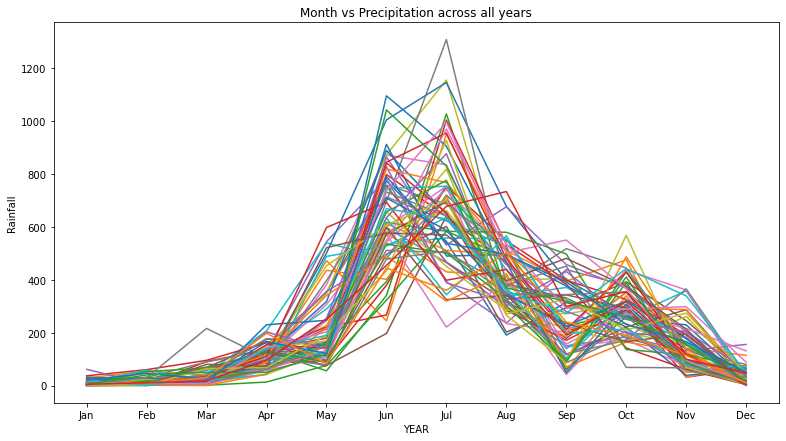

In [7]:
plt.figure(figsize=(13,7))
plt.plot(rainfall_data_matrix)
plt.xlabel('YEAR')
plt.ylabel('Rainfall')
plt.title('Month vs Precipitation across all years')

Text(0.5, 1.0, 'Month vs Precipitation across all years')

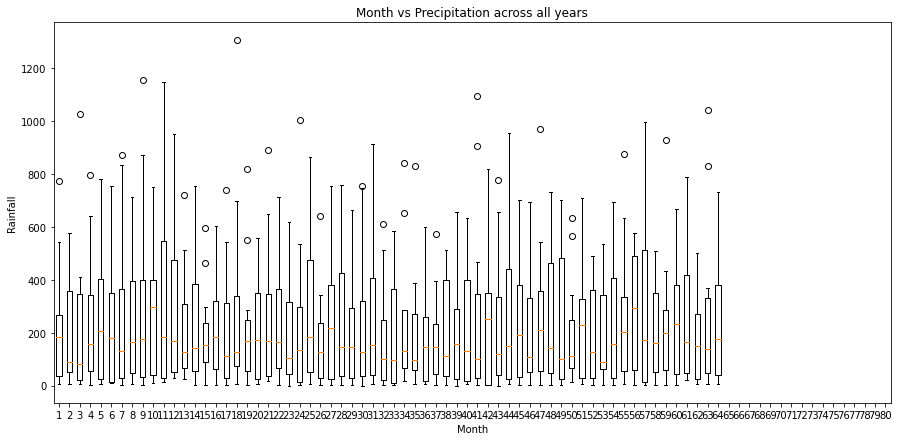

In [8]:
plt.figure(figsize=(15,7))
plt.boxplot(rainfall_data_matrix)
plt.xlabel('Month')
plt.ylabel('Rainfall')
plt.title('Month vs Precipitation across all years')

In [9]:
rainfall_data_matrix_np = rainfall_data_matrix.transpose().to_numpy()

shape = rainfall_data_matrix_np.shape
rainfall_data_matrix_np = rainfall_data_matrix_np.reshape((shape[0] * shape[1], 1))

In [10]:
rainfall_data = pd.DataFrame({'Precipitation': rainfall_data_matrix_np[:,0]})
rainfall_data.set_index(dates, inplace=True)

test_rainfall_data = rainfall_data.loc['2002':'2015']
rainfall_data = rainfall_data.loc[: '2001']
rainfall_data.head()

,Precipitation
1951-01-01,6.6
1951-02-01,6.5
1951-03-01,41.6
1951-04-01,175.9
1951-05-01,148.5


Text(0.5, 1.0, 'Precipitation in mm')

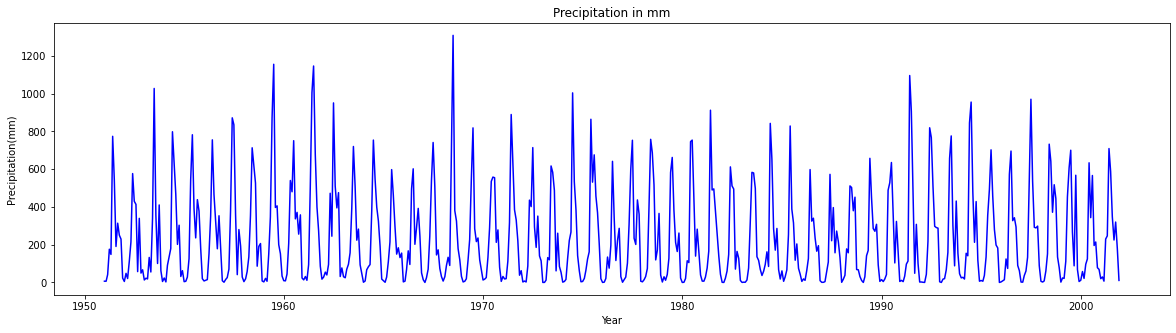

In [11]:
plt.figure(figsize=(20,5))
plt.plot(rainfall_data, color='blue')
plt.xlabel('Year')
plt.ylabel('Precipitation(mm)')
plt.title('Precipitation in mm')

In [12]:
scaler = MinMaxScaler(feature_range=(0, 1))

train_data = scaler.fit_transform(rainfall_data)
test_data = scaler.fit_transform(test_rainfall_data)

In [13]:
rainfall_data.head()

,Precipitation
1951-01-01,6.6
1951-02-01,6.5
1951-03-01,41.6
1951-04-01,175.9
1951-05-01,148.5


In [14]:
train_data[:5]

array([[0.0050424 ],
       [0.004966  ],
       [0.03178241],
       [0.13438765],
       [0.11345405]])

In [15]:
scaler.inverse_transform(train_data[:5])

array([[  5.65569562],
       [  5.57606387],
       [ 33.52680877],
       [140.47225151],
       [118.6531515 ]])

In [16]:
print("Shape of train data: " + str(train_data.shape))
print("Shape of test data: " + str(test_data.shape))

Shape of train data: (612, 1)
Shape of test data: (168, 1)


In [17]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []

    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    
    return np.array(dataX), np.array(dataY)

In [18]:
look_back = 12
trainX, trainY = create_dataset(train_data, look_back)
testX, testY = create_dataset(test_data, look_back)

In [19]:
testY

array([7.67533340e-04, 5.03693754e-02, 6.31296172e-02, 1.22517509e-01,
       8.50043174e-02, 5.12520388e-01, 4.80859637e-01, 3.13441428e-01,
       8.84582174e-02, 3.72541495e-01, 8.20301257e-02, 7.19562506e-03,
       2.20665835e-03, 5.56461671e-03, 3.28120503e-02, 1.04480476e-01,
       5.73251463e-01, 6.64875756e-01, 3.81655953e-01, 4.21087979e-01,
       1.83824235e-01, 3.04518853e-01, 1.13307109e-01, 9.59416675e-04,
       1.75573251e-02, 5.94838338e-03, 2.43691835e-02, 1.94281877e-01,
       1.31344143e-01, 6.08749880e-01, 8.41120599e-01, 2.88784419e-01,
       4.13412645e-01, 2.39950110e-01, 1.93418402e-01, 5.95797755e-02,
       8.25098340e-03, 1.91883335e-04, 7.64655090e-02, 6.96536506e-02,
       4.99664204e-01, 5.53295596e-01, 5.45908088e-01, 3.79929003e-01,
       4.61287537e-01, 3.59205603e-01, 2.03971985e-01, 1.43912501e-03,
       0.00000000e+00, 4.98896671e-03, 7.29156673e-03, 1.37196584e-01,
       1.94089993e-01, 7.07090089e-01, 9.55291183e-01, 4.81723112e-01,
      

In [20]:
print("Shape of train input: " + str(trainX.shape))
print("Shape of train labels: " + str(trainY.shape))
print("Shape of test input: " + str(testX.shape))
print("Shape of test labels: " + str(testY.shape))

Shape of train input: (599, 12)
Shape of train labels: (599,)
Shape of test input: (155, 12)
Shape of test labels: (155,)


In [21]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [22]:
print("Shape of train input: " + str(trainX.shape))
print("Shape of train labels: " + str(trainY.shape))
print("Shape of test input: " + str(testX.shape))
print("Shape of test labels: " + str(testY.shape))

Shape of train input: (599, 1, 12)
Shape of train labels: (599,)
Shape of test input: (155, 1, 12)
Shape of test labels: (155,)


In [23]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [24]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import pydot
import graphviz

def plot_keras_model(model, show_shapes=True, show_layer_names=True):
    return SVG(model_to_dot(model, show_shapes=show_shapes, show_layer_names=show_layer_names)   
   
plot_keras_model(model, show_shapes=True, show_layer_names=False)

SyntaxError: invalid syntax (Temp/ipykernel_6976/3163105180.py, line 9)

In [25]:
model.fit(trainX, trainY, epochs=500, batch_size=1, verbose=2)

Epoch 1/500
599/599 - 2s - loss: 0.0175 - 2s/epoch - 4ms/step
Epoch 2/500
599/599 - 1s - loss: 0.0116 - 709ms/epoch - 1ms/step
Epoch 3/500
599/599 - 1s - loss: 0.0108 - 668ms/epoch - 1ms/step
Epoch 4/500
599/599 - 1s - loss: 0.0103 - 667ms/epoch - 1ms/step
Epoch 5/500
599/599 - 1s - loss: 0.0104 - 669ms/epoch - 1ms/step
Epoch 6/500
599/599 - 1s - loss: 0.0102 - 666ms/epoch - 1ms/step
Epoch 7/500
599/599 - 1s - loss: 0.0102 - 684ms/epoch - 1ms/step
Epoch 8/500
599/599 - 1s - loss: 0.0099 - 667ms/epoch - 1ms/step
Epoch 9/500
599/599 - 1s - loss: 0.0100 - 668ms/epoch - 1ms/step
Epoch 10/500
599/599 - 1s - loss: 0.0098 - 665ms/epoch - 1ms/step
Epoch 11/500
599/599 - 1s - loss: 0.0099 - 684ms/epoch - 1ms/step
Epoch 12/500
599/599 - 1s - loss: 0.0098 - 681ms/epoch - 1ms/step
Epoch 13/500
599/599 - 1s - loss: 0.0097 - 683ms/epoch - 1ms/step
Epoch 14/500
599/599 - 1s - loss: 0.0098 - 668ms/epoch - 1ms/step
Epoch 15/500
599/599 - 1s - loss: 0.0097 - 685ms/epoch - 1ms/step
Epoch 16/500
599/599 -

Epoch 125/500
599/599 - 1s - loss: 0.0078 - 726ms/epoch - 1ms/step
Epoch 126/500
599/599 - 1s - loss: 0.0078 - 732ms/epoch - 1ms/step
Epoch 127/500
599/599 - 1s - loss: 0.0079 - 719ms/epoch - 1ms/step
Epoch 128/500
599/599 - 1s - loss: 0.0078 - 732ms/epoch - 1ms/step
Epoch 129/500
599/599 - 1s - loss: 0.0078 - 734ms/epoch - 1ms/step
Epoch 130/500
599/599 - 1s - loss: 0.0077 - 717ms/epoch - 1ms/step
Epoch 131/500
599/599 - 1s - loss: 0.0078 - 717ms/epoch - 1ms/step
Epoch 132/500
599/599 - 1s - loss: 0.0078 - 716ms/epoch - 1ms/step
Epoch 133/500
599/599 - 1s - loss: 0.0078 - 705ms/epoch - 1ms/step
Epoch 134/500
599/599 - 1s - loss: 0.0078 - 713ms/epoch - 1ms/step
Epoch 135/500
599/599 - 1s - loss: 0.0077 - 733ms/epoch - 1ms/step
Epoch 136/500
599/599 - 1s - loss: 0.0077 - 700ms/epoch - 1ms/step
Epoch 137/500
599/599 - 1s - loss: 0.0078 - 732ms/epoch - 1ms/step
Epoch 138/500
599/599 - 1s - loss: 0.0078 - 718ms/epoch - 1ms/step
Epoch 139/500
599/599 - 1s - loss: 0.0078 - 718ms/epoch - 1ms/

Epoch 248/500
599/599 - 1s - loss: 0.0071 - 732ms/epoch - 1ms/step
Epoch 249/500
599/599 - 1s - loss: 0.0071 - 733ms/epoch - 1ms/step
Epoch 250/500
599/599 - 1s - loss: 0.0071 - 718ms/epoch - 1ms/step
Epoch 251/500
599/599 - 1s - loss: 0.0071 - 732ms/epoch - 1ms/step
Epoch 252/500
599/599 - 1s - loss: 0.0071 - 733ms/epoch - 1ms/step
Epoch 253/500
599/599 - 1s - loss: 0.0071 - 702ms/epoch - 1ms/step
Epoch 254/500
599/599 - 1s - loss: 0.0070 - 716ms/epoch - 1ms/step
Epoch 255/500
599/599 - 1s - loss: 0.0070 - 717ms/epoch - 1ms/step
Epoch 256/500
599/599 - 1s - loss: 0.0070 - 735ms/epoch - 1ms/step
Epoch 257/500
599/599 - 1s - loss: 0.0070 - 732ms/epoch - 1ms/step
Epoch 258/500
599/599 - 1s - loss: 0.0070 - 718ms/epoch - 1ms/step
Epoch 259/500
599/599 - 1s - loss: 0.0071 - 731ms/epoch - 1ms/step
Epoch 260/500
599/599 - 1s - loss: 0.0070 - 718ms/epoch - 1ms/step
Epoch 261/500
599/599 - 1s - loss: 0.0071 - 724ms/epoch - 1ms/step
Epoch 262/500
599/599 - 1s - loss: 0.0070 - 727ms/epoch - 1ms/

Epoch 371/500
599/599 - 1s - loss: 0.0067 - 753ms/epoch - 1ms/step
Epoch 372/500
599/599 - 1s - loss: 0.0067 - 733ms/epoch - 1ms/step
Epoch 373/500
599/599 - 1s - loss: 0.0066 - 749ms/epoch - 1ms/step
Epoch 374/500
599/599 - 1s - loss: 0.0067 - 733ms/epoch - 1ms/step
Epoch 375/500
599/599 - 1s - loss: 0.0066 - 742ms/epoch - 1ms/step
Epoch 376/500
599/599 - 1s - loss: 0.0067 - 813ms/epoch - 1ms/step
Epoch 377/500
599/599 - 1s - loss: 0.0067 - 827ms/epoch - 1ms/step
Epoch 378/500
599/599 - 1s - loss: 0.0066 - 759ms/epoch - 1ms/step
Epoch 379/500
599/599 - 1s - loss: 0.0067 - 728ms/epoch - 1ms/step
Epoch 380/500
599/599 - 1s - loss: 0.0067 - 747ms/epoch - 1ms/step
Epoch 381/500
599/599 - 1s - loss: 0.0066 - 735ms/epoch - 1ms/step
Epoch 382/500
599/599 - 1s - loss: 0.0066 - 749ms/epoch - 1ms/step
Epoch 383/500
599/599 - 1s - loss: 0.0066 - 766ms/epoch - 1ms/step
Epoch 384/500
599/599 - 1s - loss: 0.0066 - 752ms/epoch - 1ms/step
Epoch 385/500
599/599 - 1s - loss: 0.0067 - 733ms/epoch - 1ms/

Epoch 494/500
599/599 - 1s - loss: 0.0063 - 723ms/epoch - 1ms/step
Epoch 495/500
599/599 - 1s - loss: 0.0064 - 733ms/epoch - 1ms/step
Epoch 496/500
599/599 - 1s - loss: 0.0064 - 735ms/epoch - 1ms/step
Epoch 497/500
599/599 - 1s - loss: 0.0064 - 732ms/epoch - 1ms/step
Epoch 498/500
599/599 - 1s - loss: 0.0064 - 734ms/epoch - 1ms/step
Epoch 499/500
599/599 - 1s - loss: 0.0064 - 764ms/epoch - 1ms/step
Epoch 500/500
599/599 - 1s - loss: 0.0064 - 742ms/epoch - 1ms/step


In [26]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [27]:
testY.shape

(155,)

In [28]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
# testPredictInTrain = scaler.inverse_transform(testPredictInTrain)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [29]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 82.01 RMSE


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [30]:
dates = pd.date_range(start='1951-01', freq='MS', periods=599)

In [31]:
trainActual = pd.DataFrame({'Precipitation': trainY[0]})
trainActual.index = dates

trainPredictdf = pd.DataFrame({'Precipitation': trainPredict[:,0]})
trainPredictdf.index = dates

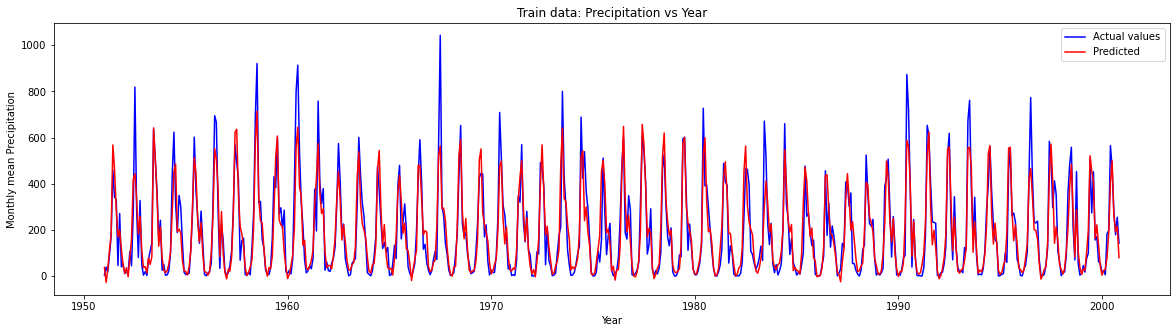

In [32]:
plt.figure(figsize=(20,5))
plt.plot(trainActual, color='blue', label='Actual values')
plt.plot(trainPredictdf, color='red', label='Predicted')
plt.title('Train data: Precipitation vs Year')
plt.xlabel('Year')
plt.ylabel('Monthly mean Precipitation')
plt.legend(loc='best')

In [33]:
testDates = pd.date_range(start='2002-01', freq='MS', periods=155)

In [34]:
testActual = pd.DataFrame({'Precipitation': testY[0]})
testActual.index = testDates

testPredictdf = pd.DataFrame({'Precipitation': testPredict[:,0]})
testPredictdf.index = testDates
testPredictdf.tail(24)


,Precipitation
2012-12-01,16.007351
2013-01-01,-21.775568
2013-02-01,20.602278
2013-03-01,42.839523
2013-04-01,157.848099
2013-05-01,245.877213
2013-06-01,436.102051
2013-07-01,563.712830
2013-08-01,290.343048
2013-09-01,296.977142


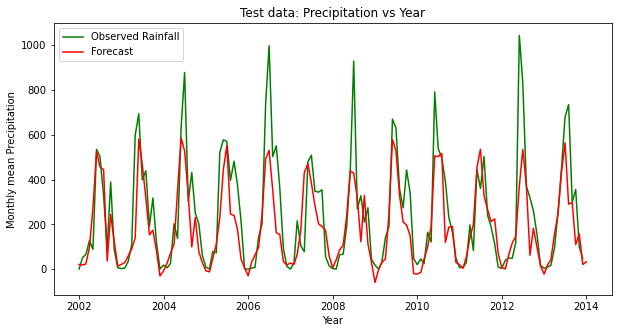

In [35]:
plt.figure(figsize=(10,5))
plt.plot(testActual, color='green', label='Observed Rainfall')
plt.plot(testPredictdf, color='red', label='Forecast')
plt.title('Test data: Precipitation vs Year')
plt.xlabel('Year')
plt.ylabel('Monthly mean Precipitation')
plt.legend(loc='best')

In [ ]:
trainPredict = model.predict(trainX)